In [ ]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

# Ass-Loss

In [ ]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer([i for i in range(0, 181)])
mlb.fit_transform([[160,  98, 174]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0]])

In [ ]:
mlb.classes_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
root_dataset_path =  ("/content/drive/MyDrive/DOA/SNS/200/DOA3")

In [ ]:
def create_dataset(df, dataset_type):
  
    data = np.transpose(df[dataset_type], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [ ]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, test)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader

In [ ]:
def create_dataloader(root_path, dataset_type, ss):
    # Loading all dataset 
    logging.info('Data prepration started')
    df1  = sio.loadmat(root_path + "/SNR_SNS_0_3_200.mat")
    df2  = sio.loadmat(root_path + "/SNR_SNS_10_3_200.mat")
    df3  = sio.loadmat(root_path + "/SNR_SNS_20_3_200.mat")
    df4  = sio.loadmat(root_path + "/SNR_SNS_30_3_200.mat")
    df5  = sio.loadmat(root_path + "/SNR_SNS_40_3_200.mat")
    df = [df1, df2, df3, df4, df5]

    new_train_dataset_list = []
    new_test_dataset_list = []
    train_dataset_list_label = []
    test_dataset_list_label = []

    dataset_len = 0
    if dataset_type == "SNS":
        dataset_len = ss//10
    if dataset_type == "NS":
        dataset_len = ss

    for file in df:
        X_train, X_test, y_train, y_test = create_dataset(file, dataset_type+"_data")
        new_train_dataset_list.extend(X_train)
        new_test_dataset_list.append(X_test.tolist())
        train_dataset_list_label.extend(y_train)
        test_dataset_list_label.append(y_test.tolist())

    # Deleteing all unused memory
    del df

    # Dividing into different channels
    logging.info('Dividing your dataset into 3 channel')

    for idx, data in enumerate(new_train_dataset_list):
        new = np.zeros((3, 8, dataset_len))
        for j in range(0, data.shape[0]):
            for k in range(0, data.shape[1]):
                new[0][j][k] = data[j][k].real
                new[1][j][k] = data[j][k].imag
                new[2][j][k] = cmath.phase(data[j][k])
        new_train_dataset_list[idx] = new

    for idx, data in enumerate(new_test_dataset_list):
        for i, ndata in enumerate(data):
            new = np.zeros((3, 8, dataset_len))
            for j in range(0, 8):
                for k in range(0, dataset_len):
                    new[0][j][k] = ndata[j][k].real
                    new[1][j][k] = ndata[j][k].imag
                    new[2][j][k] = cmath.phase(ndata[j][k])
            new_test_dataset_list[idx][i] = new

    # Generaring train loader
    logging.info('Creating Train dataloader')
    doa_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

    # Deleteing all unused memory
    del new_train_dataset_list
    del train_dataset_list_label

    test_dataset_list = []
    logging.info('Creating Validation dataloader')
    for idx, data in enumerate(new_test_dataset_list):
        f = get_data(data, test_dataset_list_label[idx], 128, False)
        test_dataset_list.append(f)

    # Deleteing all unused memory
    del new_test_dataset_list
    del new
    logging.info('Your dataset is ready !!')
    return doa_train_loader ,test_dataset_list

In [ ]:
doa_train_loader , test_dataset_list = create_dataloader(root_dataset_path, "SNS", 200)

2021-06-23 22:02:55,671 - Data prepration started
2021-06-23 22:03:06,412 - Dividing your dataset into 3 channel
2021-06-23 22:06:48,313 - Creating Train dataloader
2021-06-23 22:06:51,611 - Creating Validation dataloader
2021-06-23 22:06:52,156 - Your dataset is ready !!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((3, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.7)
        self.dropout1 = nn.Dropout(0.6)
        self.relu = nn.ReLU(inplace=True)
        self.ff = nn.Flatten()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout1(out)
        out = self.adp_pool(out)
        out = self.linear(out)
        out = self.dropout1(out)
        out = self.flat(out)
        # out = self.ff(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    print(model(image).size())


torch.Size([1, 1, 3, 181])


In [29]:
a = torch.rand(1,  3, 181)
b = torch.rand( 1, 3, 181)
losss = criterion(a.cuda(), b.cuda())

In [30]:
losss

tensor(108.2385, device='cuda:0')

In [27]:
num_epochs = 30
doa = 3
weights_dir = root_dataset_path

autoencoder = ResNet34()
# criterion = nn.CrossEntropyLoss()
criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
if ('SNS_DOA_{}_200_ASL_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
    print("Pre-trained available for DOA_{}_20_ASL_model.pth".format(doa))
    autoencoder = torch.load(os.path.join(weights_dir, 'SNS_DOA_{}_200_ASL_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.0001, weight_decay=1e-5)
	criterion = criterion.cuda()

Pre-trained available for DOA_3_20_ASL_model.pth
Tesla P100-PCIE-16GB


In [ ]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [28]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
#         for j,(features, labels) in enumerate(doa_train_loader, 0):
#             features, labels = Variable(features.cuda()), Variable(labels.cuda())
#             optimizer.zero_grad()
#             enn = classification_model(features.float())
#             auto_outputs = torch.transpose(enn, 2, 3)
#             auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0],181, doa))
#             ff = []
#             for k in labels.detach().cpu().numpy():
#               jj = []
#               for j in np.array(k):
#                 jj.append(mlb.fit_transform([[j]]))
#               ff.append(jj)
#             # a = torch.tensor(mlb.fit_transform([k for k in labels.detach().cpu().numpy()])).cuda()
#             a = torch.tensor(ff)
#             a = torch.transpose(a, 2, 3)
#             a = torch.reshape(a.cuda(), (a.shape[0],181, doa))
#             losss = criterion(auto_outputs.cuda(), a)
#             losss.backward()
#             optimizer.step()
# #           exp_scheduler.step()
#             training_loss += losss.item()

#             _, pred = torch.max(auto_outputs, 1)

#             train_total+= labels.reshape(-1).size(0)

#             train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

#             epoch_loss += auto_outputs.shape[0] * losss.item()
#             training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()   

#         loss_res['training'].append(training_loss/len(doa_train_loader))
#         acc_res['training'].append((100*(train_correct/train_total)))
#         mae_res['training'].append(training_mae/(64*len(doa_train_loader)*181))
#         print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
#                       .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*64*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0],181, doa))
                    ff = []
                    for k in labels.detach().cpu().numpy():
                      jj = []
                      for j in np.array(k):
                        jj.append(mlb.fit_transform([[j]]))
                      ff.append(jj)
                    # a = torch.tensor(mlb.fit_transform([k for k in labels.detach().cpu().numpy()])).cuda()
                    b = torch.tensor(ff)
                    b = torch.transpose(b, 2, 3)
                    b = torch.reshape(b.cuda(), (b.shape[0],181, doa))
                    # b = torch.tensor(mlb.fit_transform(labels.type(torch.LongTensor).cuda())).cuda()
                    loss = criterion(auto_outputs.cuda(), b)

                    _, pred = torch.max(auto_outputs, 1)
                    print(pred[0], "PRED")
                    print(labels[0], "LAbels")
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
                    # validation_mae += torch.abs(pred.cuda() - labels).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*128*181)))

                total_valdation_loss+=validation_loss
            torch.save( classification_model, weights_dir+ "/SNS_DOA_{}_200_ASL_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( classification_model, weights_dir+ "/DOA_{}_200_ASL_best_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
tensor([ 34, 127, 127], device='cuda:0') PRED
tensor([101,  40,  26], device='cuda:0') LAbels
tensor([ 59, 123, 123], device='cuda:0') PRED
tensor([178, 154,   8], device='cuda:0') LAbels
tensor([145, 145, 144], device='cuda:0') PRED
tensor([156,  92,  74], device='cuda:0') LAbels
tensor([147, 146, 146], device='cuda:0') PRED
tensor([166, 130,  76], device='cuda:0') LAbels
tensor([ 44,  44, 153], device='cuda:0') PRED
tensor([133,  41, 100], device='cuda:0') LAbels
tensor([32, 84, 84], device='cuda:0') PRED
tensor([ 40, 126, 163], device='cuda:0') LAbels
tensor([146, 145, 145], device='cuda:0') PRED
tensor([101,  24,  75], device='cuda:0') LAbels
tensor([176, 176, 176], device='cuda:0') PRED
tensor([175,   3, 162], device='cuda:0') LAbels
tensor([143, 143, 142], device='cuda:0') PRED
tensor([ 29, 179,  68], device='cuda:0') LAbels
tensor([104,  29,  29], device='cuda:0') PRED
tensor([ 88, 129,  72], device='cuda:0') LAbels
tensor([ 66, 143, 143], device='cuda:0'

KeyboardInterrupt: ignored

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(64*len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*64*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*128*181)))

                total_valdation_loss+=validation_loss
            torch.save( classification_model, weights_dir+ "/SNS_DOA_{}_200_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( classification_model, weights_dir+ "/DOA_{}_200_best_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/30], Training Loss: 1.2470, Training Accuracy: 58.4929, Training MAE: 0.06907327846185715
SNR [0dB], Validation Loss: 3.0628, Validation Accuracy: 16.3178, Validation MAE: 0.22071611047382714
SNR [10dB], Validation Loss: 1.8109, Validation Accuracy: 42.0667, Validation MAE: 0.081633638449293
SNR [20dB], Validation Loss: 0.9318, Validation Accuracy: 68.5889, Validation MAE: 0.033230376205637235
SNR [30dB], Validation Loss: 0.5720, Validation Accuracy: 81.0533, Validation MAE: 0.023183643131379342
SNR [40dB], Validation Loss: 0.5095, Validation Accuracy: 83.8667, Validation MAE: 0.019863385499578612


Epoch [2/30], Training Loss: 1.2317, Training Accuracy: 58.9347, Training MAE: 0.06868199734031269
SNR [0dB], Validation Loss: 3.0600, Validation Accuracy: 16.1867, Validation MAE: 0.22199234478883792
SNR [10dB], Validation Loss: 1.7990, Validation Accuracy: 42.3622, Validation MAE: 0.0783375228251709
SNR [20dB], Validation Loss: 0.9179, Validation Accuracy:

In [ ]:
# SNS DOA-2 200 Samples
print("=== Metrics ===")
print("==== DOA-{} ====".format(doa))
print("= MAE =_= Acc =")
print("{:.4f}".format(min(mae_res[0])), "  {:.2f}".format(acc_res[0][mae_res[0].index(min(mae_res[0]))]))
print("{:.4f}".format(min(mae_res[10])), "  {:.2f}".format(acc_res[10][mae_res[10].index(min(mae_res[10]))]))
print("{:.4f}".format(min(mae_res[20])), "  {:.2f}".format(acc_res[20][mae_res[20].index(min(mae_res[20]))]))
print("{:.4f}".format(min(mae_res[30])), "  {:.2f}".format(acc_res[30][mae_res[30].index(min(mae_res[30]))]))
print("{:.4f}".format(min(mae_res[40])), "  {:.2f}".format(acc_res[40][mae_res[40].index(min(mae_res[40]))]))

In [ ]:
# SNS DOA-2 200 Samples
print("=== Metrics ===")
print("==== DOA-{} ====".format(doa))
print("= MAE =_= Acc =")
print("{:.4f}".format(min(mae_res[0])), "  {:.2f}".format(acc_res[0][mae_res[0].index(min(mae_res[0]))]))
print("{:.4f}".format(min(mae_res[10])), "  {:.2f}".format(acc_res[10][mae_res[10].index(min(mae_res[10]))]))
print("{:.4f}".format(min(mae_res[20])), "  {:.2f}".format(acc_res[20][mae_res[20].index(min(mae_res[20]))]))
print("{:.4f}".format(min(mae_res[30])), "  {:.2f}".format(acc_res[30][mae_res[30].index(min(mae_res[30]))]))
print("{:.4f}".format(min(mae_res[40])), "  {:.2f}".format(acc_res[40][mae_res[40].index(min(mae_res[40]))]))

=== Metrics ===
==== DOA-3 ====
= MAE =_= Acc =
0.2151   16.24
0.0775   41.75
0.0320   68.07
0.0183   84.43
0.0155   87.15


In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(doa))
plt.legend(fontsize=14)
plt.show()

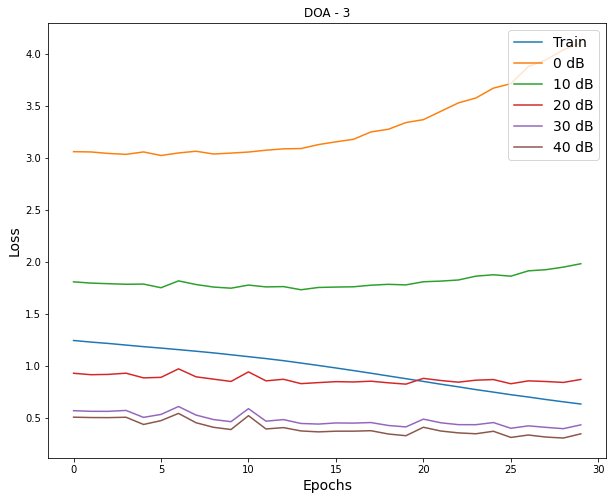

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(doa))
plt.legend(fontsize=14)
plt.show()